# Zomato Restaurant Data Analysis & Prediction Pipeline

This notebook performs comprehensive data preprocessing, feature engineering, clustering analysis, and predictive modeling on Zomato restaurant data. The goal is to predict restaurant success and identify meaningful restaurant clusters.

## Overview
- **Data Source**: Zomato restaurant dataset with features like ratings, votes, location, cuisines, and review sentiments
- **Objectives**:
  1. Clean and preprocess restaurant data
  2. Engineer meaningful features from text and numerical data
  3. Perform clustering analysis to identify restaurant segments
  4. Build predictive models for restaurant success
  5. Create reusable transformation pipelines

# Library Imports

## Import Required Libraries

This section imports all necessary libraries for:
- **Data manipulation**: `numpy`, `pandas`
- **Visualization**: `matplotlib`, `seaborn`, `plotly`
- **Machine Learning**: `sklearn` (preprocessing, modeling, clustering, dimensionality reduction)
- **Advanced encoding**: `category_encoders`
- **Gradient boosting**: `catboost`
- **Model persistence**: `joblib`, `pickle`
- **Utilities**: `ast` for parsing, `warnings` for clean output

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder, MultiLabelBinarizer, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator , TransformerMixin
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

---
# Data Loading

## Load the Zomato Dataset

**Input**: CSV file containing restaurant data with features including:
- Restaurant name, location, cuisine types
- Rating, votes, cost for two people
- Online order and table booking availability
- Review text and sentiment scores
- Restaurant type and chain information

**Output**: Pandas DataFrame `df_final` with all restaurant records

In [2]:
df_final=pd.read_csv('/kaggle/input/datasets/ddsstt/zomoto-final/df_final.csv')

## Create Working Copy

**Purpose**: Create a copy of the original dataset to preserve the raw data while performing transformations

**Best Practice**: Always work on a copy to maintain data integrity and enable easy reversion if needed

In [3]:
df=df_final.copy()

---
# Initial Data Exploration

## Preview Dataset

**Purpose**: Display the first few rows to understand:
- Data structure and column names
- Data types and formats
- Sample values and patterns
- Presence of missing values

In [4]:
df.head()

Unnamed: 0                   name online_order book_table  rate  votes  \
0           0                  jalsa          Yes        Yes   4.1    775   
1           1         spice elephant          Yes         No   4.1    787   
2           2        san churro cafe          Yes         No   3.8    918   
3           3  addhuri udupi bhojana           No         No   3.7     88   
4           4          grand village           No         No   3.8    166   

       location            rest_type  \
0  banashankari        casual dining   
1  banashankari        casual dining   
2  banashankari  cafe& casual dining   
3  banashankari          quick bites   
4  basavanagudi        casual dining   

                                          dish_liked  \
0  Pasta, Lunch Buffet, Masala Papad, Paneer Laja...   
1  Momos, Lunch Buffet, Chocolate Nirvana, Thai G...   
2  Churros, Cannelloni, Minestrone Soup, Hot Choc...   
3                                        Masala Dosa   
4                                Panipuri, Gol Gappe   

                         cuisines  ...  chain_label  \
0  chinese, mughlai, north indian  ...        Chain   
1     chinese, north indian, thai  ...        Chain   
2          cafe, italian, mexican  ...        Chain   
3      north indian, south indian  ...        Chain   
4        north indian, rajasthani  ...        Chain   

                            cuisines_list rate_group  \
0  ['chinese', 'mughlai', 'north indian']        4-5   
1     ['chinese', 'north indian', 'thai']        4-5   
2          ['cafe', 'italian', 'mexican']        3-4   
3        ['north indian', 'south indian']        3-4   
4          ['north indian', 'rajasthani']        3-4   

                                      parsed_reviews  review_rating  \
0  [('Rated 4.0', 'RATED\n  A beautiful place to ...       4.100000   
1  [('Rated 4.0', 'RATED\n  Had been here for din...       3.571429   
2  [('Rated 3.0', "RATED\n  Ambience is not that ...       3.150000   
3  [('Rated 4.0', "RATED\n  Great food and proper...       3.760870   
4  [('Rated 4.0', 'RATED\n  Very good restaurant ...       4.000000   

   pos_count neg_count  neu_count  compound_score  sentiment_score  
0       20.0       0.0        1.0        0.791260         0.600000  
1       37.0       4.0        3.0        0.583943         0.857143  
2       26.0       5.0        3.0        0.508870         0.400000  
3       31.0       3.0        6.0        0.740343         0.608696  
4        4.0       0.0        0.0        0.858300         1.000000  

[5 rows x 31 columns]

## Dataset Dimensions

**Output**: Number of rows (restaurants) and columns (features) in the dataset

In [5]:
df.shape

(51717, 31)

## Column Information

**Purpose**: Examine:
- Column names and their data types
- Non-null counts to identify missing values
- Memory usage of the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          51717 non-null  int64  
 1   name                51717 non-null  object 
 2   online_order        51717 non-null  object 
 3   book_table          51717 non-null  object 
 4   rate                41665 non-null  float64
 5   votes               51717 non-null  int64  
 6   location            51696 non-null  object 
 7   rest_type           51490 non-null  object 
 8   dish_liked          23639 non-null  object 
 9   cuisines            51672 non-null  object 
 10  cost2pepole         51371 non-null  float64
 11  reviews_list        51717 non-null  object 
 12  type                51717 non-null  object 
 13  city                51717 non-null  object 
 14  item_id             51717 non-null  int64  
 15  rate_missing        51717 non-null  bool   
 16  rate

## Check for Duplicate Records

**Purpose**: Identify any duplicate restaurant entries in the dataset

**Output**: Count of duplicate rows (if any exist)

In [7]:
df.duplicated().sum()

np.int64(0)

## Missing Value Analysis

**Purpose**: Identify columns with missing data and quantify the extent

**Output**: Count and percentage of missing values per column

**Importance**: Critical for deciding imputation strategies or feature removal

In [8]:
df.isnull().sum()

Unnamed: 0                0
name                      0
online_order              0
book_table                0
rate                  10052
votes                     0
location                 21
rest_type               227
dish_liked            28078
cuisines                 45
cost2pepole             346
reviews_list              0
type                      0
city                      0
item_id                   0
rate_missing              0
rate_missing_label        0
is_chain                  0
chain_size                0
num_of_rest_types         0
cuisines_count            0
chain_label               0
cuisines_list             0
rate_group            10052
parsed_reviews            0
review_rating         35249
pos_count             35249
neg_count             35249
neu_count             35249
compound_score        35249
sentiment_score       35249
dtype: int64

In [9]:
df.isnull().mean()*100

Unnamed: 0             0.000000
name                   0.000000
online_order           0.000000
book_table             0.000000
rate                  19.436549
votes                  0.000000
location               0.040606
rest_type              0.438927
dish_liked            54.291626
cuisines               0.087012
cost2pepole            0.669026
reviews_list           0.000000
type                   0.000000
city                   0.000000
item_id                0.000000
rate_missing           0.000000
rate_missing_label     0.000000
is_chain               0.000000
chain_size             0.000000
num_of_rest_types      0.000000
cuisines_count         0.000000
chain_label            0.000000
cuisines_list          0.000000
rate_group            19.436549
parsed_reviews         0.000000
review_rating         68.157472
pos_count             68.157472
neg_count             68.157472
neu_count             68.157472
compound_score        68.157472
sentiment_score       68.157472
dtype: f

In [10]:
df.columns

Index(['Unnamed: 0', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'dish_liked', 'cuisines', 'cost2pepole',
       'reviews_list', 'type', 'city', 'item_id', 'rate_missing',
       'rate_missing_label', 'is_chain', 'chain_size', 'num_of_rest_types',
       'cuisines_count', 'chain_label', 'cuisines_list', 'rate_group',
       'parsed_reviews', 'review_rating', 'pos_count', 'neg_count',
       'neu_count', 'compound_score', 'sentiment_score'],
      dtype='object')

---
# Data Preprocessing & Cleaning

In [11]:
df['rate_missing'].unique()

array([False,  True])

In [12]:
df['chain_label'].unique()

array(['Chain', 'Single Outlet'], dtype=object)

In [13]:
df['is_chain'].unique()

array([1, 0])

In [14]:
df['cuisines'].head()

0    chinese, mughlai, north indian
1       chinese, north indian, thai
2            cafe, italian, mexican
3        north indian, south indian
4          north indian, rajasthani
Name: cuisines, dtype: object

In [15]:
df['cuisines_list'].head()

0    ['chinese', 'mughlai', 'north indian']
1       ['chinese', 'north indian', 'thai']
2            ['cafe', 'italian', 'mexican']
3          ['north indian', 'south indian']
4            ['north indian', 'rajasthani']
Name: cuisines_list, dtype: object

In [16]:
df['location'].unique()

array(['banashankari', 'basavanagudi', 'mysore road', 'jayanagar',
       'kumaraswamy layout', 'rajarajeshwari nagar', 'vijay nagar',
       'uttarahalli', 'jp nagar', 'south bangalore', 'city market',
       'nagarbhavi', 'bannerghatta road', 'btm', 'kanakapura road',
       'bommanahalli', nan, 'cv raman nagar', 'electronic city', 'hsr',
       'marathahalli', 'sarjapur road', 'wilson garden', 'shanti nagar',
       'koramangala 5th block', 'koramangala 8th block', 'richmond road',
       'koramangala 7th block', 'jalahalli', 'koramangala 4th block',
       'bellandur', 'whitefield', 'east bangalore', 'old airport road',
       'indiranagar', 'koramangala 1st block', 'frazer town', 'rt nagar',
       'mg road', 'brigade road', 'lavelle road', 'church street',
       'ulsoor', 'residency road', 'shivajinagar', 'infantry road',
       'st. marks road', 'cunningham road', 'race course road',
       'commercial street', 'vasanth nagar', 'hbr layout', 'domlur',
       'ejipura', 'jeevan 

In [17]:
df['city'].unique()

array(['banashankari', 'bannerghatta road', 'basavanagudi', 'bellandur',
       'brigade road', 'brookefield', 'btm', 'church street',
       'electronic city', 'frazer town', 'hsr', 'indiranagar',
       'jayanagar', 'jp nagar', 'kalyan nagar', 'kammanahalli',
       'koramangala 4th block', 'koramangala 5th block',
       'koramangala 6th block', 'koramangala 7th block', 'lavelle road',
       'malleshwaram', 'marathahalli', 'mg road', 'new bel road',
       'old airport road', 'rajajinagar', 'residency road',
       'sarjapur road', 'whitefield'], dtype=object)

In [18]:
additional_city=df[~df['city'].isin(df['location'])]
print(additional_city)

Empty DataFrame
Columns: [Unnamed: 0, name, online_order, book_table, rate, votes, location, rest_type, dish_liked, cuisines, cost2pepole, reviews_list, type, city, item_id, rate_missing, rate_missing_label, is_chain, chain_size, num_of_rest_types, cuisines_count, chain_label, cuisines_list, rate_group, parsed_reviews, review_rating, pos_count, neg_count, neu_count, compound_score, sentiment_score]
Index: []

[0 rows x 31 columns]


# Drop Unnecessary Columns

This section removes columns that are unnecessary for analysis or modeling:

- **Redundant identifiers**: `Unnamed: 0`, `name`, `item_id`  
- **Text-heavy features**: `dish_liked`, `reviews_list`, `parsed_reviews`  
- **Derived/intermediate features**: `rate_missing_label`, `chain_label`, `rate_group`  
- **Location duplicates**: `city` (keeping `location` instead)  
- **Raw sentiment data**: `review_rating`, `pos_count`, `neg_count`, `neu_count`, `compound_score`, `sentiment_score`  
- **Binary flags**: `is_chain` (reconstructed later)


In [19]:
df=df.drop(columns=['Unnamed: 0','name', 'dish_liked', 'reviews_list','rate_missing_label',
                   'chain_label','parsed_reviews','city','cuisines','review_rating', 'pos_count', 'neg_count', 'neu_count',
       'compound_score', 'sentiment_score','rate_group','is_chain'])

## Handle Missing Values

This section deals with missing data in the dataset:

- **Imputation Strategy**: Use `IterativeImputer` along with `MinMaxScaler` for numerical features to fill missing values intelligently.  
- **Drop rows with missing critical categorical values**:
  - `location`
  - `rest_type`
  - `cost2pepole`


In [20]:
df=df.dropna(subset=['location','rest_type','cost2pepole'])

### Encode binary features

In [21]:
df['online_map']=df['online_order'].map({'Yes' : 1,"No":0})
df['book_map']=df['book_table'].map({'Yes' : 1,"No":0})

### Log transformation for skewed features

In [22]:
df['log_votes']=np.log1p(df['votes'])
df['log_cost']=np.log1p(df['cost2pepole'])

## Iterative Imputation on Scaled Features

This section performs imputation on numerical features after scaling:

- **Features to impute**: `rate`, `log_votes`, `log_cost`, `online_map`  
- **Strategy**:
  1. **Scale** the features using `MinMaxScaler`  
  2. **Impute** missing values using `IterativeImputer`  
  3. **Inverse scale** to return features to original range  
- **Maximum iterations**: 10


In [23]:
impute_cols = ['rate', 'log_votes', 'log_cost', 'online_map']

In [24]:
scaler = MinMaxScaler()
df_scaled = df.copy()

df_scaled[impute_cols] = scaler.fit_transform(df[impute_cols])

In [25]:
imputer = IterativeImputer(max_iter=10, random_state=42)

df_scaled[impute_cols] = pd.DataFrame(
    imputer.fit_transform(df_scaled[impute_cols]),
    columns=impute_cols,
    index=df_scaled.index
)

In [26]:
df[impute_cols] = scaler.inverse_transform(df_scaled[impute_cols])

In [27]:
rate_scaled = (df['rate'] - df['rate'].min()) / (df['rate'].max() - df['rate'].min())
vote_scaled = (df['log_votes'] - df['log_votes'].min()) / (df['log_votes'].max() - df['log_votes'].min())

## Creating Success Labels

This section defines a target variable `success` based on restaurant ratings and votes.


In [28]:
low_votes = df['votes'].quantile(0.33)
high_votes = df['votes'].quantile(0.66)

def assign_success(row):
    if row['rate'] >= 4 and row['votes'] > high_votes:
        return 'high'
    elif row['rate'] >= 3 and row['votes'] >= low_votes:
        return 'medium'
    else:
        return 'low'

df['success'] = df.apply(assign_success, axis=1)

In [29]:
# df['success_score'] = (rate_scaled * 0.7) + (vote_scaled * 0.3)
# df['success'] = pd.qcut(df['success_score'], q=3, labels=['low', 'medium', 'high'])

In [30]:
df['success'].value_counts()

success
medium    21842
low       18743
high      10582
Name: count, dtype: int64

In [31]:
df.head()

online_order book_table  rate  votes      location            rest_type  \
0          Yes        Yes   4.1    775  banashankari        casual dining   
1          Yes         No   4.1    787  banashankari        casual dining   
2          Yes         No   3.8    918  banashankari  cafe& casual dining   
3           No         No   3.7     88  banashankari          quick bites   
4           No         No   3.8    166  basavanagudi        casual dining   

   cost2pepole    type  item_id  rate_missing  chain_size  num_of_rest_types  \
0        800.0  buffet        0         False          11                  1   
1        800.0  buffet        1         False           4                  1   
2        800.0  buffet        2         False          11                  2   
3        300.0  buffet        3         False           2                  1   
4        600.0  buffet        4         False           4                  1   

   cuisines_count                           cuisines_list  online_map  \
0               3  ['chinese', 'mughlai', 'north indian']         1.0   
1               3     ['chinese', 'north indian', 'thai']         1.0   
2               3          ['cafe', 'italian', 'mexican']         1.0   
3               2        ['north indian', 'south indian']         0.0   
4               2          ['north indian', 'rajasthani']         0.0   

   book_map  log_votes  log_cost success  
0         1   6.654153  6.685861    high  
1         0   6.669498  6.685861    high  
2         0   6.823286  6.685861  medium  
3         0   4.488636  5.707110  medium  
4         0   5.117994  6.398595  medium

In [32]:
df.isnull().sum()

online_order         0
book_table           0
rate                 0
votes                0
location             0
rest_type            0
cost2pepole          0
type                 0
item_id              0
rate_missing         0
chain_size           0
num_of_rest_types    0
cuisines_count       0
cuisines_list        0
online_map           0
book_map             0
log_votes            0
log_cost             0
success              0
dtype: int64

In [33]:
df.columns

Index(['online_order', 'book_table', 'rate', 'votes', 'location', 'rest_type',
       'cost2pepole', 'type', 'item_id', 'rate_missing', 'chain_size',
       'num_of_rest_types', 'cuisines_count', 'cuisines_list', 'online_map',
       'book_map', 'log_votes', 'log_cost', 'success'],
      dtype='object')

_________
# Feature Engineering

## Global Preprocessing

This section includes general feature engineering applied to all models.

## Interaction Features
 Business Logic Interactions

## Cuisine List Processing

- **Convert string representations to lists** using `ast.literal_eval`  
- **Extract primary cuisine**: take the first element of the list, or `'other'` if the list is empty

## Custom Transformers
RareCategoryGrouper:
Groups rare categories (< 1% frequency) into 'other':


In [34]:
df['cuisines_list'].apply(type).value_counts()

cuisines_list
<class 'str'>    51167
Name: count, dtype: int64

In [35]:
def global_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convert string representation of list to actual list
    df['cuisines_list'] = df['cuisines_list'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else []
    )

    # Extract primary cuisine
    df['primary_cuisine'] = df['cuisines_list'].apply(
        lambda x: x[0] if len(x) > 0 else 'other'
    )

    return df


df = global_preprocessing(df)

In [36]:
def create_interaction_features(df):
    """Explicit business logic interactions"""

    # 1. Quality × Popularity (CRITICAL)
    df['rate_votes_interaction'] = df['rate'] * np.log1p(df['votes'])

    # 2. Value Propositions
    df['rate_per_cost'] = df['rate'] / (df['cost2pepole'] + 1)
    df['cost_per_cuisine'] = df['cost2pepole'] / (df['cuisines_count'] + 1)

    # 3. Chain Performance
    df['votes_per_chain'] = df['votes'] / (df['chain_size'] + 1)
    df['is_standalone'] = (df['chain_size'] == 1).astype(int)

    # 4. Service Level
    df['full_service'] = (
        (df['online_order'] == 'Yes') &
        (df['book_table'] == 'Yes')
    ).astype(int)

    # 5. Menu Complexity
    df['menu_diversity'] = df['num_of_rest_types'] * df['cuisines_count']
    df['is_specialized'] = (df['cuisines_count'] <= 2).astype(int)

    return df


df = create_interaction_features(df)

In [37]:
df

online_order book_table      rate  votes                    location  \
0              Yes        Yes  4.100000    775                banashankari   
1              Yes         No  4.100000    787                banashankari   
2              Yes         No  3.800000    918                banashankari   
3               No         No  3.700000     88                banashankari   
4               No         No  3.800000    166                basavanagudi   
...            ...        ...       ...    ...                         ...   
51712           No         No  3.600000     27                  whitefield   
51713           No         No  2.995594      0                  whitefield   
51714           No         No  3.022149      0                  whitefield   
51715           No        Yes  4.300000    236  itpl main road, whitefield   
51716           No         No  3.400000     13  itpl main road, whitefield   

                 rest_type  cost2pepole         type  item_id  rate_missing  \
0            casual dining        800.0       buffet        0         False   
1            casual dining        800.0       buffet        1         False   
2      cafe& casual dining        800.0       buffet        2         False   
3              quick bites        300.0       buffet        3         False   
4            casual dining        600.0       buffet        4         False   
...                    ...          ...          ...      ...           ...   
51712                  bar       1500.0  pubs & bars    51712         False   
51713                  bar        600.0  pubs & bars    51713          True   
51714                  bar       2000.0  pubs & bars    51714          True   
51715                  bar       2500.0  pubs & bars    51715         False   
51716   bar& casual dining       1500.0  pubs & bars    51716         False   

       ...  success  primary_cuisine  rate_votes_interaction rate_per_cost  \
0      ...     high          chinese               27.282025      0.005119   
1      ...     high          chinese               27.344942      0.005119   
2      ...   medium             cafe               25.928487      0.004744   
3      ...   medium     north indian               16.607955      0.012292   
4      ...   medium     north indian               19.448376      0.006323   
...    ...      ...              ...                     ...           ...   
51712  ...   medium      continental               11.995936      0.002398   
51713  ...      low      finger food                0.000000      0.004984   
51714  ...      low      finger food                0.000000      0.001510   
51715  ...     high      finger food               23.512659      0.001719   
51716  ...   medium      continental                8.972795      0.002265   

       cost_per_cuisine  votes_per_chain  is_standalone  full_service  \
0                 200.0        64.583333              0             1   
1                 200.0       157.400000              0             0   
2                 200.0        76.500000              0             0   
3                 100.0        29.333333              0             0   
4                 200.0        33.200000              0             0   
...                 ...              ...            ...           ...   
51712             750.0         6.750000              0             0   
51713             300.0         0.000000              0             0   
51714            1000.0         0.000000              1             0   
51715            1250.0        59.000000              0             0   
51716             375.0         4.333333              0             0   

      menu_diversity is_specialized  
0                  3              0  
1                  3              0  
2                  6              0  
3                  2              1  
4                  2              1  
...              ...            ...  
51712              1              1  
51

In [38]:
df.columns

Index(['online_order', 'book_table', 'rate', 'votes', 'location', 'rest_type',
       'cost2pepole', 'type', 'item_id', 'rate_missing', 'chain_size',
       'num_of_rest_types', 'cuisines_count', 'cuisines_list', 'online_map',
       'book_map', 'log_votes', 'log_cost', 'success', 'primary_cuisine',
       'rate_votes_interaction', 'rate_per_cost', 'cost_per_cuisine',
       'votes_per_chain', 'is_standalone', 'full_service', 'menu_diversity',
       'is_specialized'],
      dtype='object')

In [39]:
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.frequent_categories_ = None

    def fit(self, x, y=None):
        freq = x.value_counts(normalize=True)
        self.frequent_categories_ = freq[freq >= self.threshold].index
        return self

    def transform(self, x):
        return x.where(x.isin(self.frequent_categories_), 'other')


# split data

In [40]:
x=df.drop(columns=['rate', 'votes','log_votes', 'success','online_map','log_cost','book_map'])
y=df['success']

In [41]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

## get_top_cuisines

In [42]:
def get_top_n_cuisines(x_train, n=20):
    return (
        x_train['cuisines_list']
        .explode()
        .value_counts()
        .head(n)
        .index
        .tolist()
    )

top_n = 20
top_cuisines = get_top_n_cuisines(x, top_n)

## TopNCuisineEncoder:
Multi-label binarization for top N cuisines

In [43]:
class TopNCuisineEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_cuisines):
        self.top_cuisines = top_cuisines

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        x= x['cuisines_list']
        data = np.zeros((len(x), len(self.top_cuisines)))

        for i, cuisines in enumerate(x):
            for j, c in enumerate(self.top_cuisines):
                if c in cuisines:
                    data[i, j] = 1

        return pd.DataFrame(
            data,
            columns=[f'cuisine_{c}' for c in self.top_cuisines],
            index=x.index
        )


____________
# Random Forest Pipeline




### Feature Groups

In [44]:
binary_features = [
    'online_order', 'book_table', 'rate_missing',
    'is_standalone', 'full_service', 'is_specialized'
]

high_cardinality_features = ['location', 'rest_type']

other_categorical_features = ['primary_cuisine', 'type']

cost_feature =['cost2pepole', 'cost_per_cuisine']

count_features = [
    'chain_size', 'num_of_rest_types', 'cuisines_count','menu_diversity'
   # 'rate_per_cost',
]

## Sub-Pipelines

### Binary Transformer
- Maps `True/False` and `Yes/No` to `1/0`

### High Cardinality Categorical Pipeline
- `RareCategoryGrouper` with `threshold=0.01`  
- `TargetEncoder`

### Other Categorical Pipeline
- `TargetEncoder` only

### Cost Pipeline
- Log transformation using `np.log1p`  
- StandardScaler

### Count Pipeline
- StandardScaler only


In [45]:
binary_mapping = {True: 1, False: 0, 'Yes': 1, 'No': 0}

def binary_mapper(x):
    return x.replace(binary_mapping).astype(int)

binary_transformer = FunctionTransformer(
    binary_mapper,
    feature_names_out='one-to-one'
)

In [46]:
# High-cardinality categorical
high_cardinality_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(threshold=0.01)),
    ('target', TargetEncoder())
])

# Other categorical
other_categorical_pipeline = Pipeline([
    ('target', TargetEncoder())
])

In [47]:
# Numerical
cost_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

In [48]:
count_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

## Pipeline Structure

In [49]:
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, binary_features),
        ('high_cat', high_cardinality_pipeline, high_cardinality_features),
        ('cat', other_categorical_pipeline, other_categorical_features),
        ('cost', cost_pipeline, cost_feature),
        ('count', 'passthrough', count_features),
        ('cuisine', TopNCuisineEncoder(top_cuisines), ['cuisines_list'])
    ],
    remainder='drop'
)

In [50]:
rf_pipeline = Pipeline([
    ('preprocessing', rf_preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])


## Train & evaluate & save

In [51]:
rf_pipeline.fit(x_train, y_train)
y_rf_pred=rf_pipeline.predict(x_test)

In [52]:
print("Accuracy:", accuracy_score(y_test, y_rf_pred))
print(classification_report(y_test,y_rf_pred))

Accuracy: 0.8960979740733502
              precision    recall  f1-score   support

        high       0.92      0.89      0.90      3175
         low       0.92      0.88      0.90      5623
      medium       0.87      0.91      0.89      6553

    accuracy                           0.90     15351
   macro avg       0.90      0.89      0.90     15351
weighted avg       0.90      0.90      0.90     15351



In [53]:
conf_matrix=confusion_matrix(y_test, y_rf_pred)

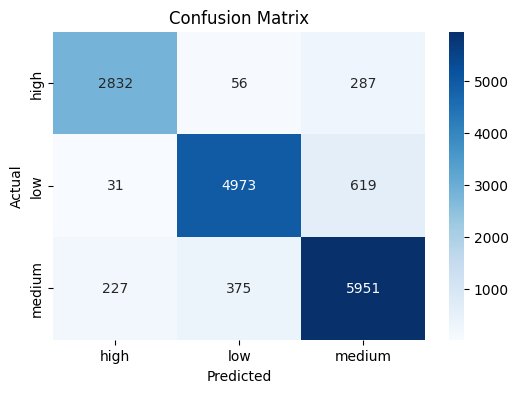

In [54]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_pipeline.classes_, yticklabels=rf_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [55]:
joblib.dump(rf_pipeline,'rf_pipeline.pkl')
joblib.dump(rf_pipeline.named_steps['model'], 'rf_model.pkl')

['rf_model.pkl']

_____________________________________________

## CatBoost Pipeline

### Why CatBoost?
CatBoost natively handles categorical features without explicit encoding, making it ideal for high-cardinality features like `location` and `rest_type`.

### Feature Groups

**Categorical Features (passed as-is)**:  
- `online_order`, `book_table`, `location`, `rest_type`  
- `type`, `rate_missing`, `primary_cuisine`  
- `is_standalone`, `full_service`, `is_specialized`  

**Cost Features**:  
- `cost2pepole`, `cost_per_cuisine`  

**Count Features**:  
- `chain_size`, `num_of_rest_types`, `cuisines_count`, `menu_diversity`


In [56]:
cat_features = [
    'online_order', 'book_table', 'location', 'rest_type',
    'type', 'rate_missing', 'primary_cuisine',
    'is_standalone', 'full_service', 'is_specialized']

cost_cat_feature =['cost2pepole','cost_per_cuisine']


cat_count_features = ['chain_size', 'num_of_rest_types', 'cuisines_count', 'menu_diversity'
                      # 'rate_per_cost'
]

In [57]:
cost_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

count_pipeline = Pipeline([
    ('scaler', StandardScaler())
])


## Pipeline Structure

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cost', cost_pipeline, cost_cat_feature),
        ('count', count_pipeline, cat_count_features),
        ('cat', 'passthrough', cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


## Critical Implementation Detail
## Categorical feature index calculation:

In [59]:
x_train_proc = preprocessor.fit_transform(x_train)
x_test_proc  = preprocessor.transform(x_test)

In [60]:
feature_names = preprocessor.get_feature_names_out()

cat_feature_indices = [
    i for i, name in enumerate(feature_names)
    if name in cat_features
]

print("Categorical feature indices:", cat_feature_indices)


Categorical feature indices: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## Model Configuration

In [61]:
cat_model = CatBoostClassifier(
    iterations=1700,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    eval_metric='TotalF1:average=Macro',
    random_seed=42,
    loss_function='MultiClass',
    verbose=100
)

## Train & evaluate & save

In [62]:
cat_model.fit(
    x_train_proc,
    y_train,
    eval_set=(x_test_proc, y_test),
    cat_features=cat_feature_indices,
    early_stopping_rounds=50
)

0:	learn: 0.6704836	test: 0.6703480	best: 0.6703480 (0)	total: 186ms	remaining: 5m 15s
100:	learn: 0.7904140	test: 0.8125389	best: 0.8126608 (99)	total: 10.8s	remaining: 2m 50s
200:	learn: 0.8068884	test: 0.8238443	best: 0.8238443 (200)	total: 21.8s	remaining: 2m 42s
300:	learn: 0.8256445	test: 0.8369828	best: 0.8369828 (300)	total: 33.2s	remaining: 2m 34s
400:	learn: 0.8429314	test: 0.8479109	best: 0.8481585 (399)	total: 44.4s	remaining: 2m 23s
500:	learn: 0.8564309	test: 0.8547616	best: 0.8552056 (489)	total: 55.7s	remaining: 2m 13s
600:	learn: 0.8669122	test: 0.8591864	best: 0.8595256 (598)	total: 1m 6s	remaining: 2m 2s
700:	learn: 0.8776755	test: 0.8640602	best: 0.8640602 (700)	total: 1m 18s	remaining: 1m 51s
800:	learn: 0.8868184	test: 0.8672929	best: 0.8672929 (800)	total: 1m 29s	remaining: 1m 40s
900:	learn: 0.8958397	test: 0.8706924	best: 0.8706924 (900)	total: 1m 40s	remaining: 1m 29s
1000:	learn: 0.9040056	test: 0.8758385	best: 0.8758385 (1000)	total: 1m 52s	remaining: 1m 18s

In [63]:
y_cat_pred = cat_model.predict(x_test_proc)

print("Accuracy:", accuracy_score(y_test, y_cat_pred))
print(classification_report(y_test, y_cat_pred))

Accuracy: 0.8925802879291251
              precision    recall  f1-score   support

        high       0.95      0.87      0.91      3175
         low       0.94      0.85      0.89      5623
      medium       0.84      0.94      0.89      6553

    accuracy                           0.89     15351
   macro avg       0.91      0.89      0.90     15351
weighted avg       0.90      0.89      0.89     15351



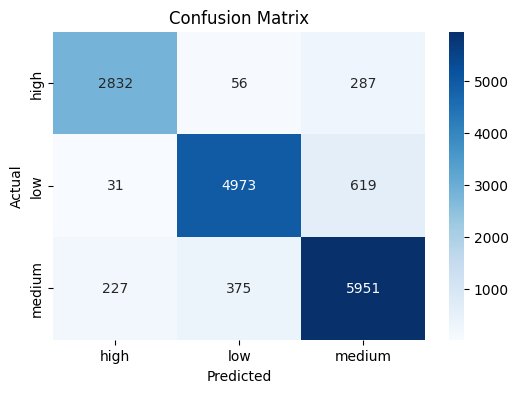

In [64]:
conf_matrix=confusion_matrix(y_test, y_rf_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_pipeline.classes_, yticklabels=rf_pipeline.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [65]:
joblib.dump(preprocessor, "cat_preprocessor.joblib")
cat_model.save_model(
    "catboost_model.cbm",
    format="cbm"
)

## Compare Between RandomForest & Catboost

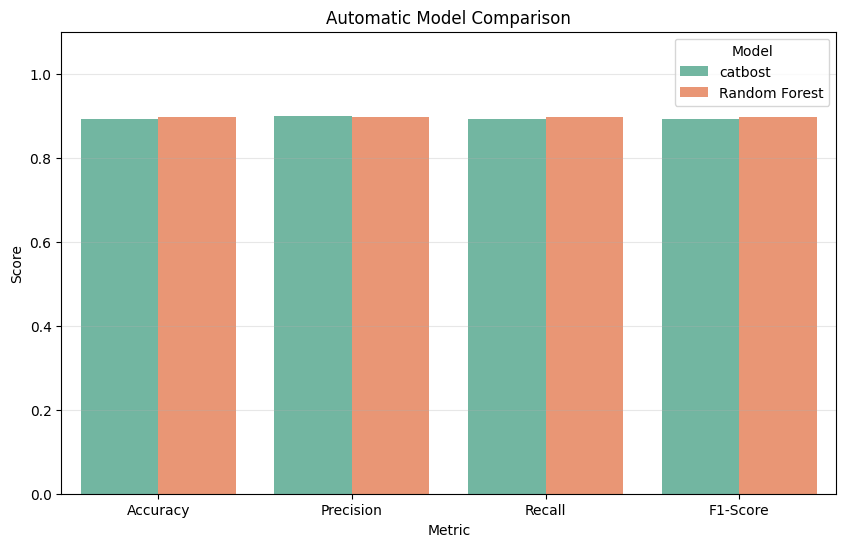

In [66]:
def get_metrics_df(y_test, y_pred, model_name):

    report = classification_report(y_test, y_pred, output_dict=True)


    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Score': [
            report['accuracy'],
            report['weighted avg']['precision'],
            report['weighted avg']['recall'],
            report['weighted avg']['f1-score']
        ],
        'Model': model_name
    }
    return pd.DataFrame(metrics)


df_model_a = get_metrics_df(y_test, y_cat_pred, "catbost")
df_model_b = get_metrics_df(y_test, y_rf_pred, "Random Forest")


all_results = pd.concat([df_model_a, df_model_b])


plt.figure(figsize=(10, 6))
sns.barplot(data=all_results, x='Metric', y='Score', hue='Model', palette='Set2')
plt.ylim(0, 1.1)
plt.title('Automatic Model Comparison')
plt.grid(axis='y', alpha=0.3)
plt.show()

______________________________________________

## Clustering Analysis

This section contains commented code for unsupervised clustering.

### Approach
- **Features**: Frequency-encoded `location` / `type`, cost, count features  
- **Method**: K-Means clustering  
- **Optimization**: Elbow method and Silhouette score to select optimal number of clusters  
- **Visualization**: PCA for 2D cluster plots  

### Use Case
Clustering helps understand restaurant segments for business insights:  
- Premium vs. budget segments  
- Service type patterns  
- Cuisine diversity clusters


In [67]:
df['success_map']=df['success'].map({'low':1, 'medium':2, 'high' : 3})

## Simplifying Location Feature

This section reduces the cardinality of the `location` feature by keeping only the top locations.

- **Top N locations**: 20  


In [68]:
# top_n = 20
# top_locations = df['location'].value_counts().nlargest(top_n).index
# df['location_simplified'] = df['location'].apply(
#     lambda x: x if x in top_locations else 'Other'
# )


In [69]:
grouper = RareCategoryGrouper(threshold=0.01)
df['location_simplified'] = grouper.fit_transform(df['location'])

## Frequency encoding for Categorical Feature

In [70]:
# Frequency encoding for location
location_freq = df['location_simplified'].value_counts(normalize=True)
df['location_freq'] = df['location_simplified'].map(location_freq)

# Frequency encoding for type
type_freq = df['type'].value_counts(normalize=True)
df['type_freq'] = df['type'].map(type_freq)


### cluster_features

In [71]:
cluster_features = [
    'online_map',
    'book_map',
    'log_cost',
    'num_of_rest_types',
    'cuisines_count',
    'location_freq',
    'type_freq'
]


In [72]:
df[cluster_features].head()

online_map  book_map  log_cost  num_of_rest_types  cuisines_count  \
0         1.0         1  6.685861                  1               3   
1         1.0         0  6.685861                  1               3   
2         1.0         0  6.685861                  2               3   
3         0.0         0  5.707110                  1               2   
4         0.0         0  6.398595                  1               2   

   location_freq  type_freq  
0       0.017707   0.017023  
1       0.017707   0.017023  
2       0.017707   0.017023  
3       0.017707   0.017023  
4       0.013368   0.017023

In [73]:
scaler = StandardScaler()
x_cluster = scaler.fit_transform(df[cluster_features])

In [74]:
x_cluster

array([[ 0.82896106,  2.63326761,  0.9010277 , ...,  0.43061354,
        -0.76174387, -2.25817619],
       [ 0.82896106, -0.37975631,  0.9010277 , ...,  0.43061354,
        -0.76174387, -2.25817619],
       [ 0.82896106, -0.37975631,  0.9010277 , ...,  0.43061354,
        -0.76174387, -2.25817619],
       ...,
       [-1.20632928, -0.37975631,  2.29752302, ..., -1.14792228,
        -0.32143533, -2.28063249],
       [-1.20632928,  2.63326761,  2.6377363 , ..., -1.14792228,
         2.01100007, -2.28063249],
       [-1.20632928, -0.37975631,  1.85896933, ...,  0.43061354,
         2.01100007, -2.28063249]])

## Elbow Method for Optimal K in K-Means

This section determines the optimal number of clusters using the **Elbow Method**.


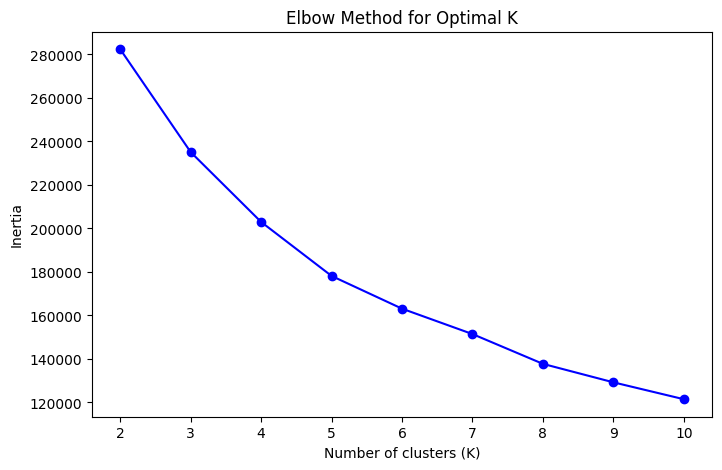

In [75]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(x_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

## Silhouette Score for Cluster Evaluation

This section evaluates K-Means clustering performance using the **Silhouette Score**, which measures how well each point lies within its cluster.

- **Range of clusters to test**: 2 to 10  
- **Procedure**: Fit K-Means, predict cluster labels, calculate Silhouette Score


In [76]:
from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(x_cluster)
    score = silhouette_score(x_cluster, labels)
    print(f"K={k}, Silhouette Score={score:.3f}")

K=2, Silhouette Score=0.367
K=3, Silhouette Score=0.241
K=4, Silhouette Score=0.263
K=5, Silhouette Score=0.273
K=6, Silhouette Score=0.281
K=7, Silhouette Score=0.254
K=8, Silhouette Score=0.270
K=9, Silhouette Score=0.277
K=10, Silhouette Score=0.289


### Clustering Visualization with K-Means and PCA



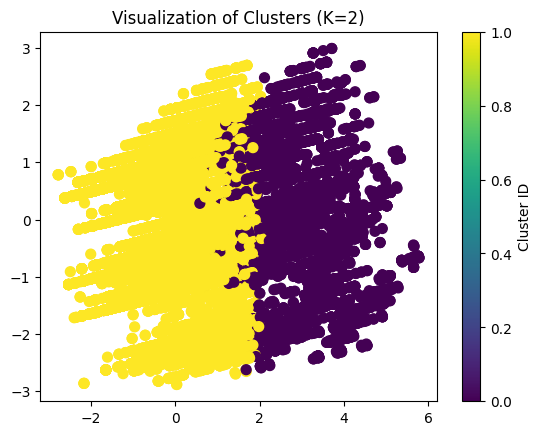

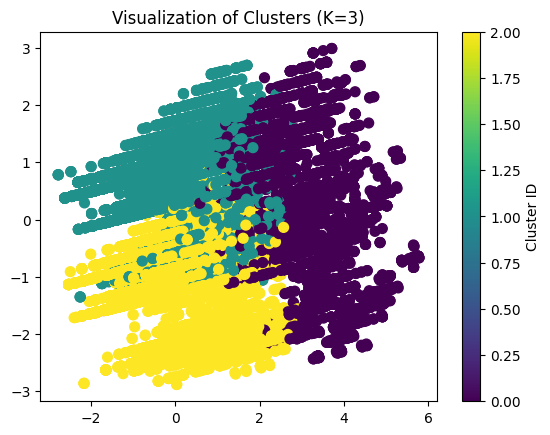

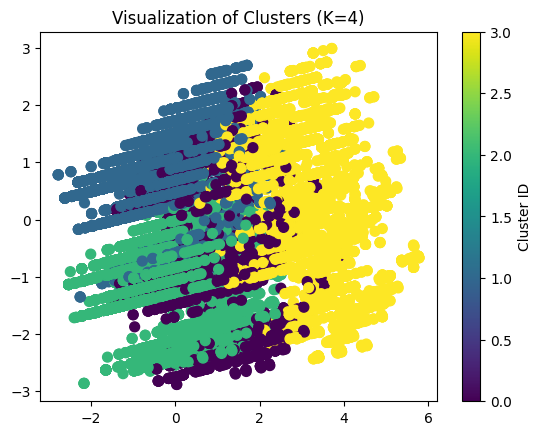

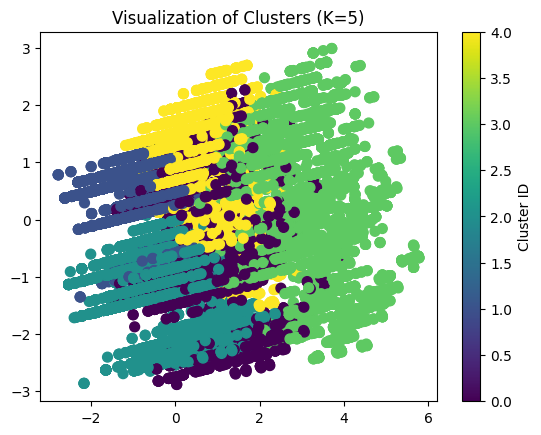

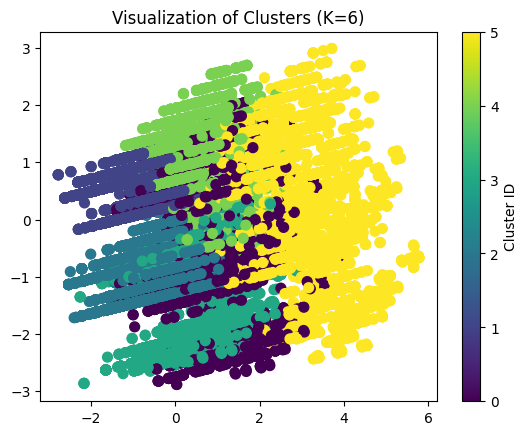

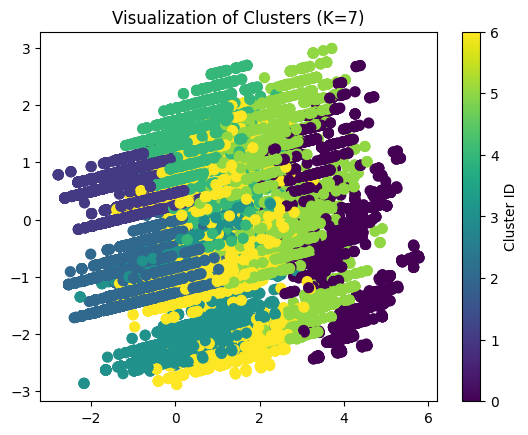

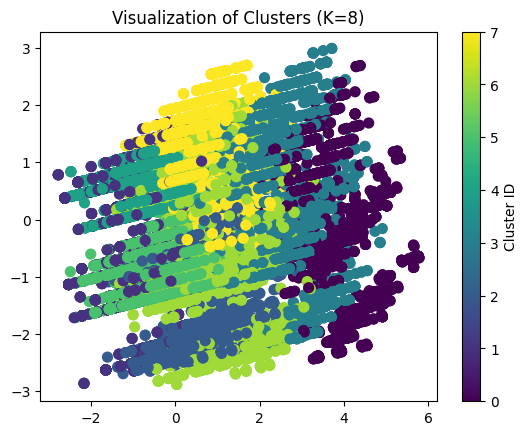

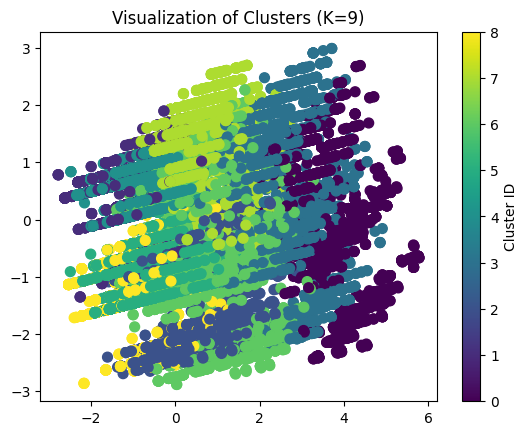

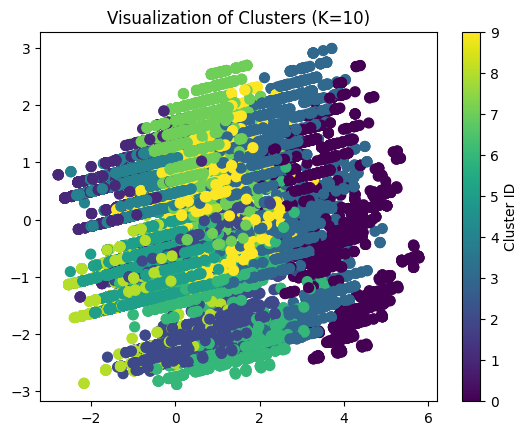

In [77]:
def plot_clusters(x_cluster, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(x_cluster)

    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(x_cluster)

    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(f'Visualization of Clusters (K={n_clusters})')
    plt.colorbar(label='Cluster ID')
    plt.show()

plot_clusters(x_cluster, 2)
plot_clusters(x_cluster, 3)
plot_clusters(x_cluster, 4)
plot_clusters(x_cluster, 5)
plot_clusters(x_cluster, 6)
plot_clusters(x_cluster, 7)
plot_clusters(x_cluster, 8)
plot_clusters(x_cluster, 9)
plot_clusters(x_cluster, 10)


### Selecting the Optimal Number of Clusters and Fitting K-Means

1. **Optimal Clusters:**  
   We set `k_optimal = 2` based on previous visualizations (or an elbow/analysis method) to define the number of clusters.


In [78]:
k_optimal = 2

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(x_cluster)

In [79]:
df['cluster'] = cluster_labels

## Cluster Analysis: Average Cost per Cluster

This section examines the **average cost per person** in each cluster to understand spending patterns.


In [80]:
df.groupby('cluster')['cost2pepole'].mean()

cluster
0    1284.562308
1     437.157616
Name: cost2pepole, dtype: float64

### Analyzing Cluster Characteristics

- **Calculating Mean Values:**  
  We compute the mean of the `online_map` and `book_map` scores for each cluster.  

This helps us understand the typical behavior of each cluster in terms of online and booking ratings, allowing us to characterize and compare clusters more effectively.


In [81]:
df.groupby('cluster')[['online_map','book_map']].mean()

online_map  book_map
cluster                      
0          0.555478  0.897965
1          0.598777  0.000159

## Cluster Analysis: Average Count Features per Cluster

This section examines average count-based features in each cluster to understand restaurant characteristics.


In [82]:
df.groupby('cluster')[['cuisines_count','num_of_rest_types']].mean()

cuisines_count  num_of_rest_types
cluster                                   
0              3.379147           1.389880
1              2.303616           1.110222

In [83]:
df['cluster'].value_counts()

cluster
1    43993
0     7174
Name: count, dtype: int64

## Cluster Visualization: Cost vs. Number of Cuisines

This section visualizes clusters in 2D using **Plotly Express scatter plot**, to explore relationships between cost and cuisine diversity.

- **X-axis**: `log_cost` (log-transformed cost per person)  
- **Y-axis**: `cuisines_count` (number of cuisines offered)  
- **Color**: `cluster` (cluster membership)  
- **Hover data**: `location`, `rest_type` for additional context


In [91]:
fig_cost_cus_cluster = px.scatter(
    df,
    x='log_cost',
    y='cuisines_count',
    color='cluster',
    hover_data=['location','rest_type']
)
fig_cost_cus_cluster.show()

### Cluster Analysis: Success Rate

1. **Mean Success Rate per Cluster:**  
   We group the dataset `df` by the `cluster` column and calculate the mean of `success_map` for each cluster.  
   - This provides a quick summary of how successful each cluster is on average.

2. **Visualizing Distribution with a Box Plot:**  
   - We use **Plotly Express** to create a box plot of `success_map` values across clusters.  
   - **X-axis:** Cluster ID  
   - **Y-axis:** `success_map` values  
   - **Color:** Cluster ID for better differentiation  
   - **Title:** `'Distribution of Success per Cluster'`  

The box plot allows us to see the spread, median, and potential outliers of success within each cluster, helping us understand which clusters tend to perform better or worse.


In [85]:
df.groupby('cluster')['success_map'].mean()

cluster
0    2.667828
1    1.705590
Name: success_map, dtype: float64

In [92]:
fig_cluster_distribution= px.box(
    df,
    x='cluster',
    y='success_map',
    color='cluster',
    title='Distribution of Success per Cluster'
)
fig_cluster_distribution.show()

In [87]:
figures = {
    "fig_cluster_distribution": fig_cluster_distribution,
    "fig_cost_cus_cluster": fig_cost_cus_cluster
}


with open("all_figures_cluster.pkl", "wb") as f:
    pickle.dump(figures, f)

print("All figures saved in 'all_figures_cluster.pkl'")

All figures saved in 'all_figures_cluster.pkl'


In [88]:
with open('cluster.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [89]:
df.duplicated(subset=[col for col in df.columns if df[col].apply(lambda x: not isinstance(x, list)).all()]).sum()


np.int64(0)

In [90]:
df.to_csv('df_perdict_cluster.csv', index=False)